**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

### Konfiguracja środowiska 

In [11]:
%pip install datasets transformers torch langdetect scikit-learn seaborn pandas matplotlib wordcloud nltk spacy jieba --quiet

Note: you may need to restart the kernel to use updated packages.


### Ładowanie danych

In [2]:
from datasets import load_dataset

ds = load_dataset("clapAI/MultiLingualSentiment")

/Users/mikolaj/Desktop/STUDIA/CDV STOPIEŃ II/I ROK/II SEMESTR/Uczenie głebokie w przetwarzaniu języka/PROJEKT/Multilingual-sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 3147478
    })
    validation: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393435
    })
    test: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393436
    })
})


### Redukcja datasetów, wymieszanie rekordów oraz podział na język + typ zbioru

In [3]:
languages = ds['train'].unique('language')
ds_types = ['train', 'validation', 'test']
drop_columns = ['source', 'domain']
ds = ds.remove_columns(drop_columns)
# Create dictionary to store datasets for each language
datasets = {}

# Split train, validation and test for each language
for lang in languages:
    datasets[lang] = {}
    for ds_type in ds_types:
        datasets[lang][ds_type] = ds[ds_type].filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc=4
            )
        
        # Reduce dataset by 100 times
        rows_counter = datasets[lang][ds_type].num_rows
        new_num_rows = round(rows_counter*0.01)
        datasets[lang][ds_type] = datasets[lang][ds_type].shuffle(seed=42)
        datasets[lang][ds_type] = datasets[lang][ds_type].select(range(new_num_rows))

### Czyszczenie datasetów z błędnych języków

W zbiorze angielskim występowały próbki niechcianych języków np. turecki

In [4]:
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"
    
for ds_type in ds_types:
        for lang in languages:
            datasets['en'][ds_type] = datasets['en'][ds_type].filter(
                lambda batch: [detect_language(x) == 'en' for x in batch['text']],
                batched=True,
                num_proc=4
            )

In [5]:
datasets['en']['train'][0]

{'text': 'Not allowed to withdraw my funds, and was told I can only cash out if I deactivate or close the account. Well if u say so.',
 'label': 'negative',
 'language': 'en'}

### Przygotowanie datasetów z wybranymi językami

W ramach naszego usecase'u wybraliśmy 3 języki - angielski, hiszpański oraz chiński. Do rekordów dodaliśmy label_id jako wartość predykcyjna do uczenia.

In [6]:
from datasets import concatenate_datasets

languages_to_process = ['en', 'es', 'zh']
labels_id = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert labels to IDs
def convert_labels_to_ids(batch):
    batch['label_id'] = [labels_id[label] for label in batch['label']]
    return batch

# train ds
train_ds_list = [datasets[lang]['train'] for lang in languages_to_process]
# Concatenate datasets for selected languages
train_ds = concatenate_datasets(train_ds_list)
train_ds = train_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
train_ds = train_ds.shuffle(seed=42)

# eval ds
eval_ds_list = [datasets[lang]['validation'] for lang in languages_to_process]
# Concatenate datasets for selected languages
eval_ds = concatenate_datasets(eval_ds_list)
eval_ds = eval_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
eval_ds = eval_ds.shuffle(seed=42)

# test ds
test_ds_list = [datasets[lang]['test'] for lang in languages_to_process]
# Concatenate datasets for selected languages
test_ds = concatenate_datasets(test_ds_list)
test_ds = test_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
test_ds = test_ds.shuffle(seed=42)

In [8]:
print(train_ds[1])

{'text': 'Ya voy a juntar pastito y agua para los camellos de los reyes magos', 'label': 'neutral', 'language': 'es', 'label_id': 1}


### Eksploracja zbioru treningowego

Jak mozna zauwazyć niestety w zbiorach dane nie są równo rozłozone między wszystkie języki i etykiety, ale to nie stanowi dla nas problemu w trenowaniu modelu.

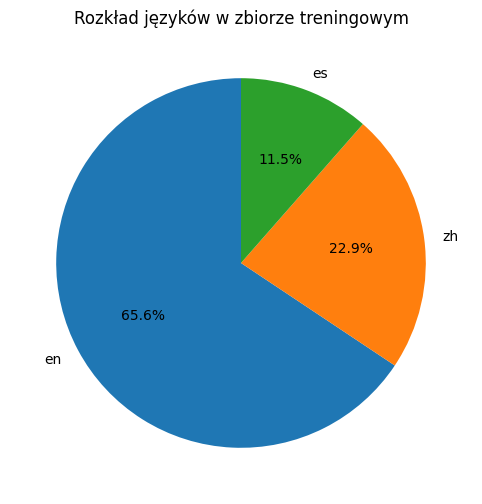

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
language_stats = train_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze treningowym')

plt.savefig('images/language_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

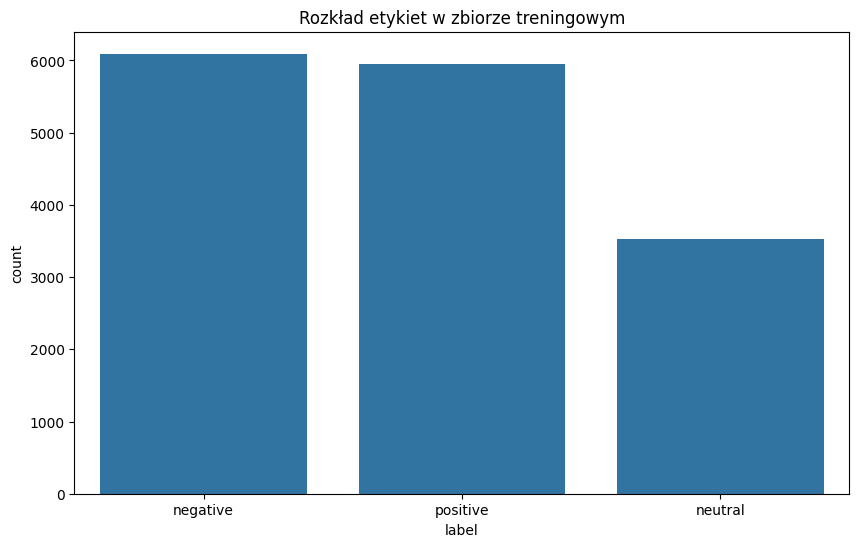

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
label_stats = train_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze treningowym')

plt.savefig('images/label_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

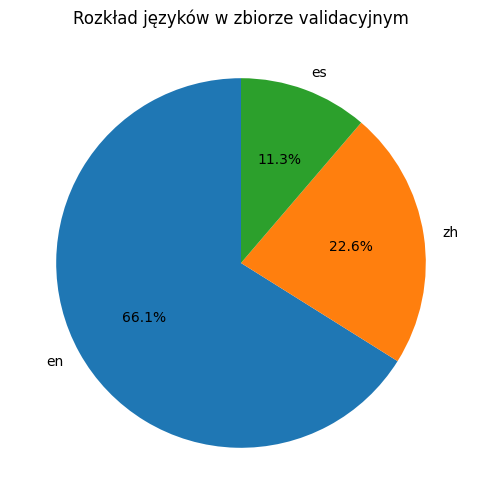

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
language_stats = eval_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze validacyjnym')

plt.savefig('images/language_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

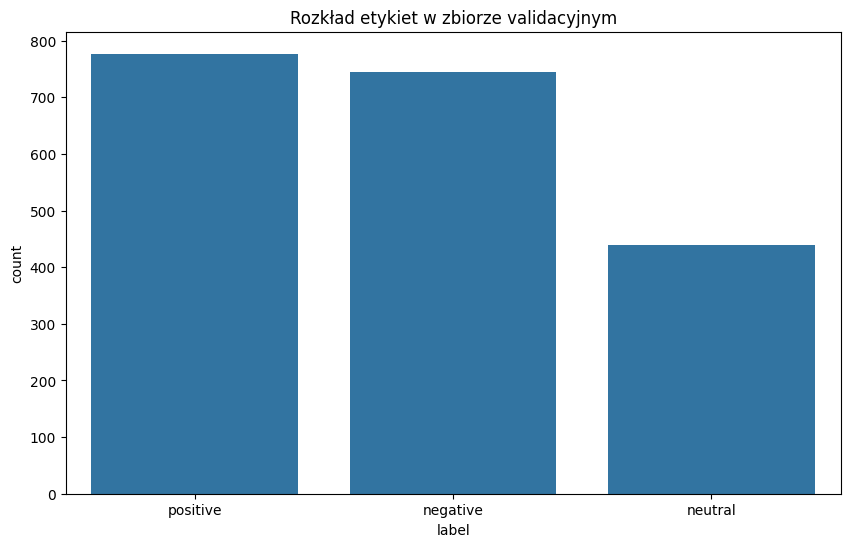

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
label_stats = eval_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze validacyjnym')

plt.savefig('images/label_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

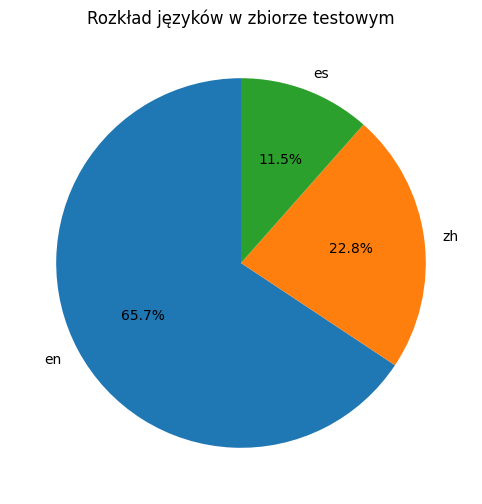

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
language_stats = test_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze testowym')

plt.savefig('images/language_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

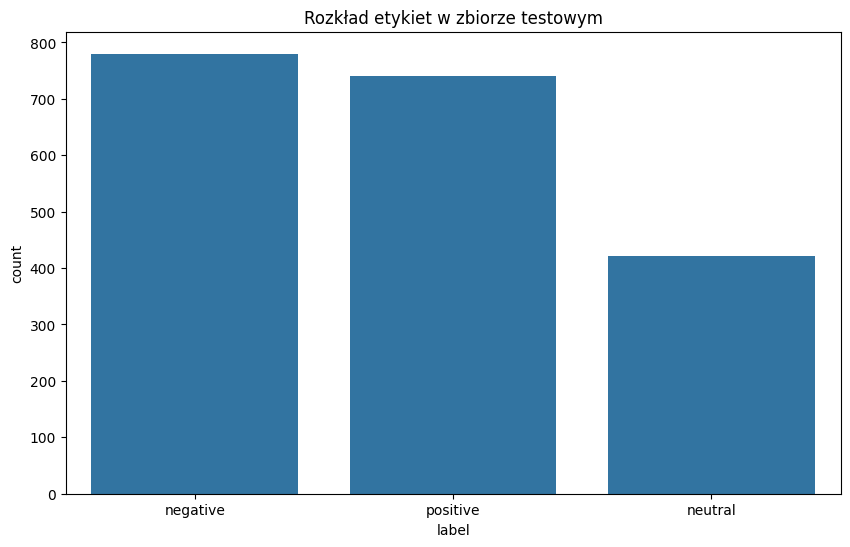

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
label_stats = test_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze testowym')

plt.savefig('images/label_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

### Wordclouds

In [15]:
import re
import nltk
import spacy
import jieba
from nltk.corpus import stopwords


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mikolaj/Desktop/STUDIA/CDV STOPIEŃ II/I ROK/II SEMESTR/Uczenie głebokie w przetwarzaniu języka/PROJEKT/Multilingual-sentiment-analysis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/mikolaj/Desktop/STUDIA/CDV STOPIEŃ II/I ROK/II SEMESTR/Uczenie głebokie w przetwarzaniu języka/PROJEKT/Multilingual-sentiment-analysis/.venv/lib

Opcjonalne: przy problemach nltk z SSL:

In [16]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [18]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("es_core_news_sm")
spacy.cli.download("zh_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 30.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 50.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7

In [17]:
nltk.download('stopwords')

# Initialize spacy models
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'zh': spacy.load('zh_core_web_sm')
}

# Get stopwords
stop_words = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'zh': set()  # Chinese doesn't use stopwords
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikolaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_special_and_digits(txt, lang):
  txt = re.sub(r'[^a-zA-Z\u4e00-\u9fff\s]', '', txt)

  if lang == 'zh':
    txt = " ".join(jieba.cut(txt))

  if lang != 'zh':
    txt = txt.lower()
  
  document = nlp_models[lang](txt)

  tokens = []
  if lang == 'zh':
    # For Chinese, we don't use lemmatization
    tokens = [token.text for token in document if 
              (not token.is_stop and not token.is_space and
              len(token.text.strip()) > 0)]

  for token in document:
    if (token.text not in stop_words.get(lang, set()) and not token.is_space and 
      len(token.text.strip()) > 0):
      tokens.append(token.lemma_)
  
  return ' '.join(tokens)

def preprocess_dataset(example):
    example['preprocessed_text'] = remove_special_and_digits(
        example['text'], 
        example['language']
    )

    return example

In [19]:
print(train_ds)

preprocessed_dataset = train_ds.map(
    preprocess_dataset,
    num_proc=4, 
    batch_size=100
)

print("Original text:", preprocessed_dataset[0]['text'])
print("Preprocessed text:", preprocessed_dataset[0]['preprocessed_text'])

Dataset({
    features: ['text', 'label', 'language', 'label_id'],
    num_rows: 15561
})


Map (num_proc=4):   0%|          | 23/15561 [00:00<05:01, 51.60 examples/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/jieba.cache
Loading model cost 0.809 seconds.
Prefix dict has been built successfully.
Dumping model to file cache /var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/jieba.cache
Dumping model to file cache /var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/jieba.cache
Loading model cost 0.796 seconds.
Prefix dict has been built successfully.
Map (num_proc=4):   0%|          | 31/15561 [00:01<10:54, 23.73 examples/s]Loading model cost 0.803 seconds.
Prefix dict has been built successfully.
Map (num_proc=4):   0%|          | 38/15561 [00:01<08:42, 29.70 examples/s]Dumping model to file cache /var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/jieba.cache
Loading model cost 0.814 seconds.
Prefix dict has been built successfully.
Map (num_proc=4): 100%|██████████| 15561/15561 [01:02<00:00, 250.5

Original text: 正好下周也准备去露营🏕️来着，露营很有意思也很开心，但是安全问题也是要做好防护的，我也是有鼻炎，有辅舒良的小绿瓶在就很安心了[可爱][可爱]，现在还有一起露营吧的联名的舒释瓶，是真香哦，我也要去参与活动[笑哈哈][笑哈哈][笑哈哈]
Preprocessed text: 正好 下周 露营 露营 有意思 开心 做好 防护 鼻炎 辅 舒良 绿瓶 安心 可爱 可爱 露营 联名 舒释 瓶 真香 参与 活动 笑 笑 笑                                                                  


Filter: 100%|██████████| 15561/15561 [00:00<00:00, 112546.39 examples/s]


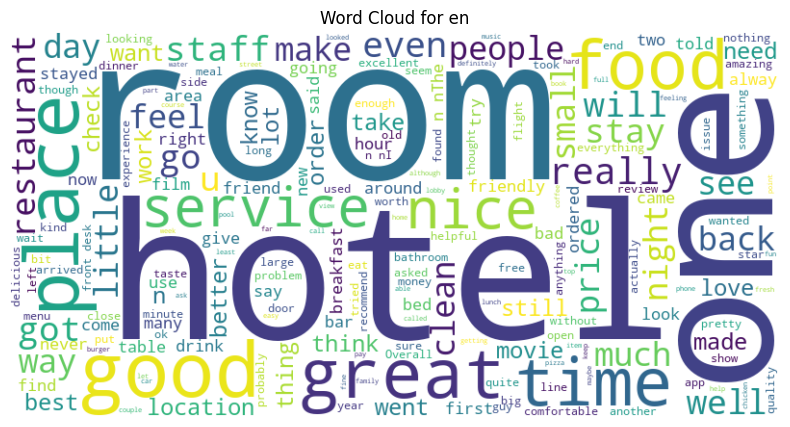

Filter: 100%|██████████| 15561/15561 [00:00<00:00, 109388.94 examples/s]


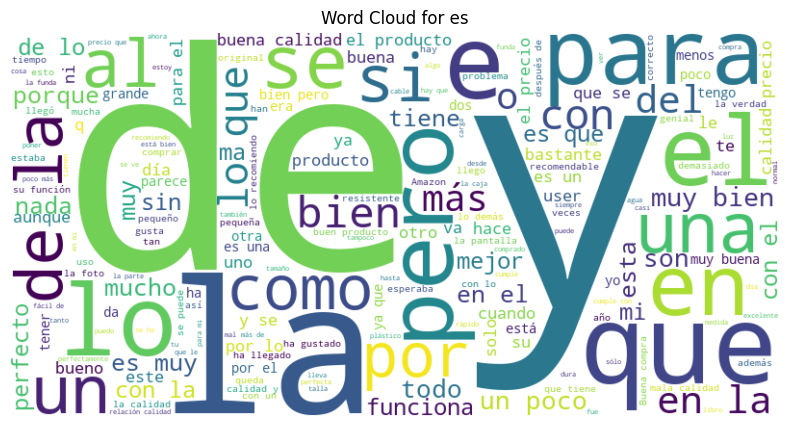

Filter: 100%|██████████| 15561/15561 [00:00<00:00, 94546.83 examples/s]


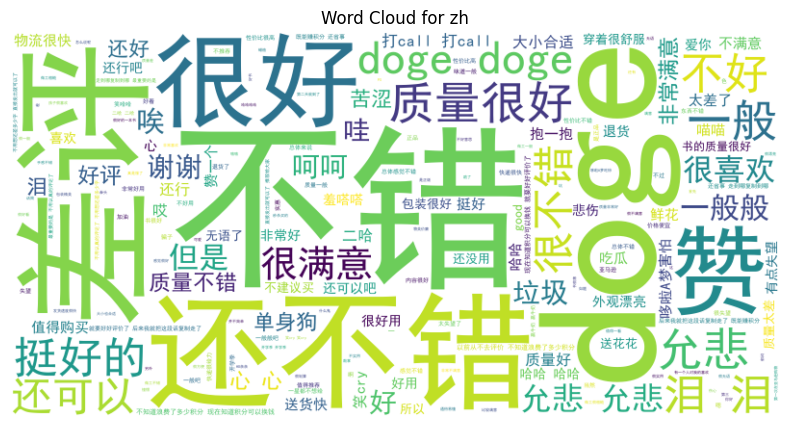

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font_path = './resources/simhei.ttf'  # Path to a Chinese font file for word cloud

# Create word cloud for each language
for lang in languages_to_process:
    # Filter dataset by language
    lang_texts = ' '.join(preprocessed_dataset.filter(
        lambda x: x['language'] == lang
    )['text'])
    
    # Create and display word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        font_path=font_path if lang == 'zh' else None,  # Use Chinese font for Chinese text
    ).generate(lang_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang}')
    plt.show()

    wordcloud.to_file(f'./wordclouds/wordcloud_{lang}.png')  # Save word cloud to file

### Tokenizacja

W ramach tego etapu załadowaliśmy juz wstępnie wytrenowany model i tokenizator z bert-base-multilingual-cased i dokonaliśmy tokenizacji zbioru treningowego i validacyjnego

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

def tokenize_and_encode(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # BERT max sequence length
        # return_tensors=None,  # Returns PyTorch tensors
        # return_special_tokens_mask=True
    )



tokenized_train_ds = train_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_train_ds = tokenized_train_ds.rename_column("label_id", "label")
tokenized_eval_ds = eval_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_eval_ds = tokenized_eval_ds.rename_column("label_id", "label")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
print(tokenized_train_ds[0])

{'label': 2, 'input_ids': [101, 3767, 3392, 5605, 10064, 5286, 7520, 1882, 1882, 1882, 131, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Trening

W ramach treningu dodaliśmy własną funkcję compute_metrics, która ma na celu obliczanie accuracy oraz f1 po validacji kazdej z epok

In [48]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

model.to('cpu')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir="./multilingual_bert_sentiment",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("./multilingual_bert_sentiment")
trainer.evaluate()

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_34965/1482221042.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 